# PROYECTO INEI BERT + KMEANS

Importando las librerías necesarias

In [ ]:
import os
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import string
import csv
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Definiendo la ruta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Proyecto INEI')

Importando la data

In [ ]:
data = pd.read_csv("2019_info (1).csv", sep=",")
data.head()

,Unnamed: 0,t1txt
0,0,NO SABE
1,1,VIOLACION A MENORES DE EDAD
2,2,EL NARCOTRAFICO EL FEMINICIDIO
3,5,LA DISCRIMINACION
4,6,EL NARCOTRAFICO


## PREPROCESAMIENTO DE LAS RESPUESTAS ABIERTAS

Ahora, aplicaremos una función para eliminar las palabras incongruentes, preposiciones, definir el idioma, etc.

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def preprocess_string(input_string):
    input_string = input_string.lower()
    cleaned_string = re.sub(r'[^\x00-\x7F]+', '', input_string)
    split_string = cleaned_string.split(" ")
    no_url_words = [word for word in split_string if "://" not in word]
    no_url_wordshashtag = [word for word in no_url_words if "#" not in word]
    no_url_wordsarroba = [word for word in no_url_wordshashtag if "@" not in word]
    no_url_salto = [word.replace('\n', ' ') for word in no_url_wordsarroba]
    no_url_string = " ".join(no_url_salto)
    no_punctuation_string = no_url_string.translate(str.maketrans("", "", string.punctuation))
    split_string = no_punctuation_string.split(" ")
    no_stopwords_strings = [word for word in split_string if word not in stopwords.words('spanish')]
    stemmed_words = [lemmatizer.lemmatize(word) for word in no_stopwords_strings]
    output_string = " ".join(stemmed_words)
    while "  " in output_string:
        output_string = output_string.replace("  ", " ")
    return output_string

Aplicamos en la columna de respuestas abiertas.

In [ ]:
preprocessed_train_data = [preprocess_string(input_string) for input_string in tqdm(data['t1txt'])]

  0%|          | 0/5672 [00:00<?, ?it/s]

In [ ]:
preprocessed_train_data

['sabe',
 'violacion menores edad',
 'narcotrafico feminicidio',
 'discriminacion',
 'narcotrafico',
 'feminicidio',
 'desnutricion infantil',
 'desigualdad economica',
 'feminicidio',
 'falta etica profesional',
 'mal manejo programas sociales',
 'falta apoyo emprendimiento empresas',
 'drogadiccion',
 'mala orientacion programas sociales',
 'incumplimiento leyes',
 'drogadiccion',
 'falta respeto mujer',
 'inmoralidad politico',
 'inmoralidad',
 'feminicidio',
 'incapacidad trabajadores',
 'drogadiccion',
 'falta valores',
 'violencia mujer',
 'injusticia',
 'sabe',
 'accidentes transito',
 'narcotrafico',
 'feminicidio',
 'drogadiccion',
 'falta profesionalidad trabajadores',
 'sabe',
 'sabe',
 'feminicidio',
 'injusticia',
 'sabe',
 'sabe',
 'falta apoyo adulto mayor',
 'violacion menores edad',
 'accidentes transito',
 'violacion menores edad',
 'feminicidio',
 'desigualdad genero',
 'contaminacion medio ambiente',
 'asignacion recursos innecesarios policia',
 'prostitucion infant

## ANÁLISIS EXPLORATORIO DE LAS PALABRAS

En esta sección, vamos a ver cuales son las palabras que más se usan en las respuestas. El objetivo es encontrar palabras que se pueden encontrar para distintos contextos.

In [ ]:
from collections import Counter
all_words = " ".join(preprocessed_train_data).split()
word_counts = Counter(all_words)
print(word_counts.most_common(10))

[('sabe', 1916), ('falta', 1034), ('contaminacion', 236), ('feminicidio', 222), ('agua', 194), ('apoyo', 191), ('servicios', 156), ('ambiental', 153), ('basicos', 145), ('violacion', 143)]


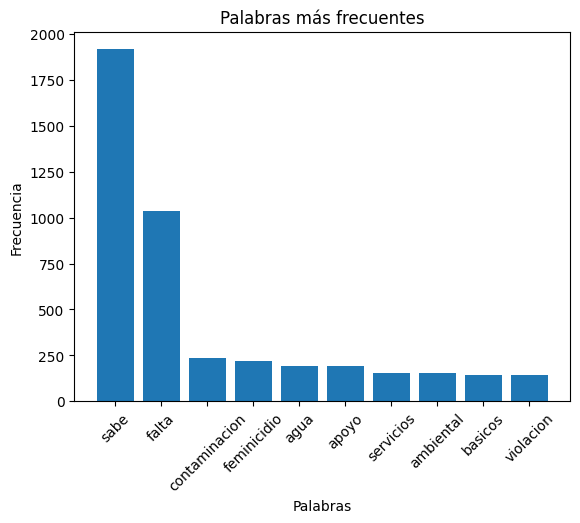

In [ ]:
stop_words = set(stopwords.words('spanish'))
filtered_words = [word for word in all_words if word.lower() not in stop_words]
filtered_word_counts = Counter(filtered_words)
import matplotlib.pyplot as plt
common_words = filtered_word_counts.most_common(10)
words, counts = zip(*common_words)
# Graficando
plt.bar(words, counts)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes')
plt.xticks(rotation=45)
plt.show()

Observamos que las palabras sabe y falta aparece con más frecuencia, comparando con las otras palabras (luego del preprocesamiento).

Conocemos que las palabras sabe y falta, por si solo, no generan mucho contexto, y aparecen en mucho de las respuestas abiertas.

Veremos que otras palabras están asociadas a la palabra falta.

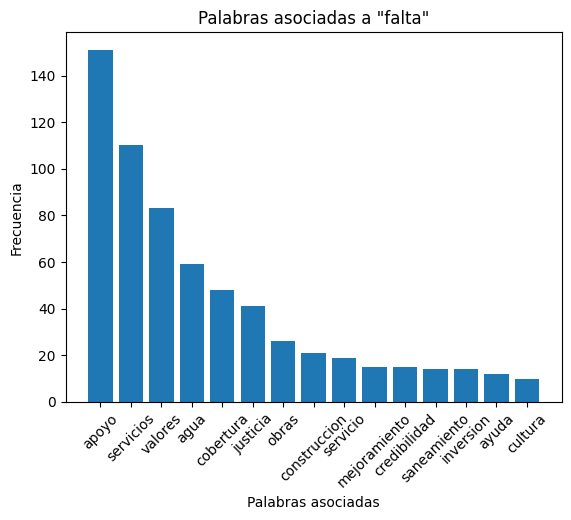

In [ ]:
falta_contexts = [text for text in preprocessed_train_data if "falta" in text.lower()]
context_words = []
for text in falta_contexts:
    words = text.split()
    if "falta" in words:
        idx = words.index("falta")
        # Agregar palabras antes y después de "falta"
        if idx > 0:
            context_words.append(words[idx - 1])
        if idx < len(words) - 1:
            context_words.append(words[idx + 1])

# Contar las co-ocurrencias
context_counts = Counter(context_words)
# Seleccionar las palabras más comunes
common_contexts = context_counts.most_common(15)
words, counts = zip(*common_contexts)

# Graficar
plt.bar(words, counts)
plt.xlabel('Palabras asociadas')
plt.ylabel('Frecuencia')
plt.title('Palabras asociadas a "falta"')
plt.xticks(rotation=45)
plt.show()

Observamos que la palabra falta está presente en varias respuestas, y estas están en diferentes contextos. Esto generaría un problema para aplicar clustering mediante kmeans, ya que su incorporación puede introducir variabilidad dentro de cada cluster (puede agrupar textos con distintas temáticas).

## PREPROCESAMIENTO DE TEXTO ELIMINANDO LA PALABRA FALTA

In [ ]:
def preprocess_string_1(input_string):
    input_string = input_string.lower()
    cleaned_string = re.sub(r'[^\x00-\x7F]+', '', input_string)
    split_string = cleaned_string.split(" ")
    no_url_words = [word for word in split_string if "://" not in word]
    no_url_wordshashtag = [word for word in no_url_words if "#" not in word]
    no_url_wordsarroba = [word for word in no_url_wordshashtag if "@" not in word]
    no_url_salto = [word.replace('\n', ' ') for word in no_url_wordsarroba]
    no_url_string = " ".join(no_url_salto)
    no_punctuation_string = no_url_string.translate(str.maketrans("", "", string.punctuation))
    split_string = no_punctuation_string.split(" ")
    stop_words = stopwords.words('spanish')
    #no_stopwords_strings = [word for word in split_string if word not in stopwords.words('spanish')]
    #no_stopwords_strings = [word for word in split_string if word not in no_stopwords_strings and word != "falta"] ##nuevo
    no_stopwords_strings = [word for word in split_string if word not in stop_words and word != "falta"]

    stemmed_words = [lemmatizer.lemmatize(word) for word in no_stopwords_strings]
    output_string = " ".join(stemmed_words)
    while "  " in output_string:
        output_string = output_string.replace("  ", " ")
    return output_string

In [ ]:
preprocessed_train_data_1 = [preprocess_string_1(input_string) for input_string in tqdm(data['t1txt'])]

  0%|          | 0/5672 [00:00<?, ?it/s]

In [ ]:
preprocessed_train_data_1

['sabe',
 'violacion menores edad',
 'narcotrafico feminicidio',
 'discriminacion',
 'narcotrafico',
 'feminicidio',
 'desnutricion infantil',
 'desigualdad economica',
 'feminicidio',
 'etica profesional',
 'mal manejo programas sociales',
 'apoyo emprendimiento empresas',
 'drogadiccion',
 'mala orientacion programas sociales',
 'incumplimiento leyes',
 'drogadiccion',
 'respeto mujer',
 'inmoralidad politico',
 'inmoralidad',
 'feminicidio',
 'incapacidad trabajadores',
 'drogadiccion',
 'valores',
 'violencia mujer',
 'injusticia',
 'sabe',
 'accidentes transito',
 'narcotrafico',
 'feminicidio',
 'drogadiccion',
 'profesionalidad trabajadores',
 'sabe',
 'sabe',
 'feminicidio',
 'injusticia',
 'sabe',
 'sabe',
 'apoyo adulto mayor',
 'violacion menores edad',
 'accidentes transito',
 'violacion menores edad',
 'feminicidio',
 'desigualdad genero',
 'contaminacion medio ambiente',
 'asignacion recursos innecesarios policia',
 'prostitucion infantil',
 'sabe',
 'sabe',
 'sabe',
 'fe

BERT (Bidirectional Encoder Representations from Transformers)

In [ ]:
from sentence_transformers import SentenceTransformer

# Modelo multilingüe preentrenado
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
embeddings = model.encode(preprocessed_train_data_1)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score,silhouette_score

# Valores para los índices Davies-Bouldin y Calinski-Harabasz
davies_bouldin_scores = []
calinski_harabasz_scores = []
inertia = []
silhouette = []
range_n_clusters = range(2, 50)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)

    # Calcular los índices
    db_score = davies_bouldin_score(embeddings, kmeans.labels_)
    ch_score = calinski_harabasz_score(embeddings, kmeans.labels_)

    davies_bouldin_scores.append(db_score)
    calinski_harabasz_scores.append(ch_score)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
    silhouette.append(silhouette_avg)

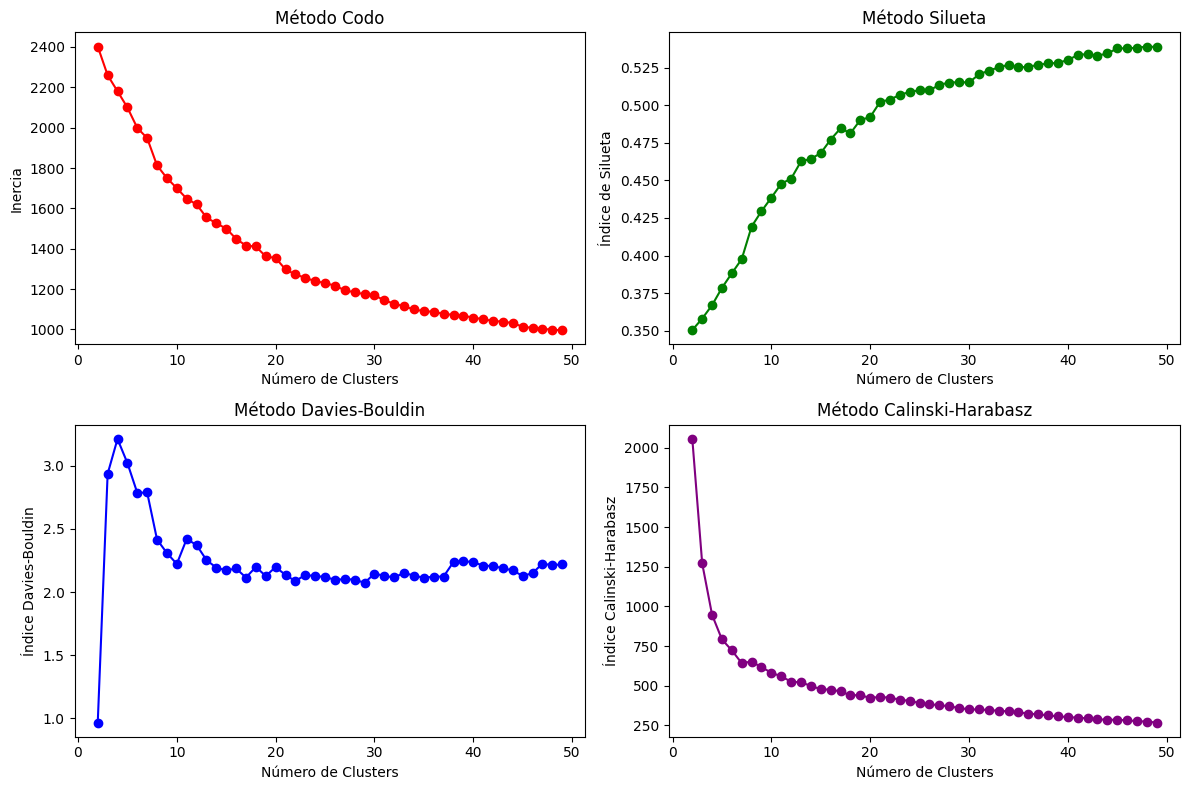

In [ ]:
# Graficar todas las métricas
plt.figure(figsize=(12, 8))

# Graficar el Método del Codo (Inercia)
plt.subplot(2, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o', color='r')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método Codo')

# Graficar el Índice de Silueta
plt.subplot(2, 2, 2)
plt.plot(range_n_clusters, silhouette, marker='o', color='g')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silueta')
plt.title('Método Silueta')

# Graficar el Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice Davies-Bouldin')
plt.title('Método Davies-Bouldin')

# Graficar el Calinski-Harabasz Index
plt.subplot(2, 2, 4)
plt.plot(range_n_clusters, calinski_harabasz_scores, marker='o', color='purple')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice Calinski-Harabasz')
plt.title('Método Calinski-Harabasz')

# Ajustar la disposición y mostrar la gráfica
plt.tight_layout()
plt.show()

Observamos que las métricas de inercia, Silueta y Calinski-Harabasz, mientras más cluster agreguemos, las métricas mejoran. Pero esto seria incorrecto debido a que podriamos generar un sobreajuste a los datos, ya que generariamos cluster demasiados específicos.

Con el método de Davies Bouldin, observamos que a partir del cluster 12, el valor del indice permanece algo estable.

In [ ]:
# Elegir número de clusters
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster1'] = kmeans.fit_predict(embeddings)
data

,Unnamed: 0,t1txt,cluster1,cluster_name,cluster_name_1
0,0,NO SABE,0,sabe responde sabes opina informa,No sabe
1,1,VIOLACION A MENORES DE EDAD,1,violacion violaciones violencia sexual mujer,Violencia contra poblaciones vulnerables
2,2,EL NARCOTRAFICO EL FEMINICIDIO,4,drogadiccion narcotrafico alcoholismo drogas d...,Transtorno por uso de sustancias
3,5,LA DISCRIMINACION,3,feminicidio feminicidios injusticia justicia d...,Violencia de género y justicia social
4,6,EL NARCOTRAFICO,4,drogadiccion narcotrafico alcoholismo drogas d...,Transtorno por uso de sustancias
...,...,...,...,...,...
5667,8295,LA AGRICULTURA ESTA OLVIDADA LOS MAYORISTAS PA...,2,desnutricion falta mala infantil sociales,desnutricion falta mala infantil sociales
5668,8296,ORDEN EN EL PERU Y MANO DURA,2,desnutricion falta mala infantil sociales,desnutricion falta mala infantil sociales
5669,8297,AUTORIDADES QUE TRABAJEN BIEN,10,apoyo falta autoridades congreso leyes,Falta de apoyo de las autoridades
5670,8298,POR LA FORMA DE SER CADA PERSONA,2,desnutricion falta mala infantil sociales,desnutricion falta mala infantil sociales


In [ ]:
db_score = davies_bouldin_score(embeddings, kmeans.labels_)
ch_score = calinski_harabasz_score(embeddings, kmeans.labels_)
inertia_1 = kmeans.inertia_
silhouette_avg_1= silhouette_score(embeddings, kmeans.labels_)

In [ ]:
df = pd.DataFrame({
    'Inercia': [inertia_1],
    'Davies-Bouldin': [db_score],
    'Calinski-Harabasz': [ch_score],
    'Silhouette': [silhouette_avg_1]
})

In [ ]:
df

,Inercia,Davies-Bouldin,Calinski-Harabasz,Silhouette
0,1619.814819,2.372376,525.170191,0.451174


OUTLIERS

Observamos que para el cluster 2, no se hizo una buena clusterización, ya que toma muchos temas.

In [ ]:
data[data['cluster1']==2].count()

,0
Unnamed: 0,894
t1txt,894
cluster1,894
cluster_name,894
cluster_name_1,894


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
spanish_stop_words = stopwords.words('spanish')
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
tfidf_matrix = vectorizer.fit_transform(data['t1txt'])

In [ ]:
cluster_names = {}
for cluster_id in range(n_clusters):
    # Filtrar textos por cluster
    cluster_texts = data[data['cluster1'] == cluster_id]['t1txt']
    # Vectorizar textos del cluster
    tfidf_cluster = vectorizer.transform(cluster_texts)
    # Sumar TF-IDF por palabra
    word_scores = tfidf_cluster.sum(axis=0).A1
    # Palabras más importante por cluster
    top_word_indices = word_scores.argsort()[::-1][:5]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_word_indices]
    cluster_names[cluster_id] = ' '.join(top_words)

# Mapear nombres al DataFrame
data['cluster_name'] = data['cluster1'].map(cluster_names)

In [ ]:
data

,Unnamed: 0,t1txt,cluster1,cluster_name
0,0,NO SABE,0,sabe responde sabes opina informa
1,1,VIOLACION A MENORES DE EDAD,1,violacion violaciones violencia sexual mujer
2,2,EL NARCOTRAFICO EL FEMINICIDIO,4,drogadiccion narcotrafico alcoholismo drogas d...
3,5,LA DISCRIMINACION,3,feminicidio feminicidios injusticia justicia d...
4,6,EL NARCOTRAFICO,4,drogadiccion narcotrafico alcoholismo drogas d...
...,...,...,...,...
5667,8295,LA AGRICULTURA ESTA OLVIDADA LOS MAYORISTAS PA...,2,desnutricion falta mala infantil sociales
5668,8296,ORDEN EN EL PERU Y MANO DURA,2,desnutricion falta mala infantil sociales
5669,8297,AUTORIDADES QUE TRABAJEN BIEN,10,apoyo falta autoridades congreso leyes
5670,8298,POR LA FORMA DE SER CADA PERSONA,2,desnutricion falta mala infantil sociales


Obtenemos los valores unicos de la columna cluster_name (las palabras que más se repiten)

In [ ]:
data['cluster_name'].unique()

array(['sabe responde sabes opina informa',
       'violacion violaciones violencia sexual mujer',
       'drogadiccion narcotrafico alcoholismo drogas droga',
       'feminicidio feminicidios injusticia justicia discriminacion',
       'desnutricion falta mala infantil sociales',
       'valores falta morales etica principios',
       'apoyo falta autoridades congreso leyes',
       'falta carreteras transito mejoramiento transporte',
       'contaminacion ambiental naturales desastres ambiente',
       'migracion venezolanos venezolana extranjeros inmigracion',
       'mineria contaminacion minera minero mineras',
       'agua falta servicios basicos desague'], dtype=object)

In [ ]:
cluster_map = {
    'sabe responde sabes opina informa':'No sabe',
    'violacion violaciones violencia sexual mujer':'Violencia contra poblaciones vulnerables',
    'drogadiccion narcotrafico alcoholismo drogas droga':'Transtorno por uso de sustancias',
    'valores falta morales etica principios':'Falta de ética',
    'apoyo falta autoridades congreso leyes':'Falta de apoyo de las autoridades',
    'contaminacion ambiental naturales desastres ambiente':'Contaminación ambiental y desastres',
    'falta carreteras transito mejoramiento transporte':'Falta de comunicación y transporte',
    'migracion venezolanos venezolana extranjeros inmigracion':'Inmigración extranjera',
    'mineria contaminacion minera minero mineras':'Problemas mineros',
    'agua falta servicios basicos desague':'Falta de saneamiento y servicios básicos',
    'feminicidio feminicidios injusticia justicia discriminacion':'Violencia de género y justicia social'
}

In [ ]:
data['cluster_name_1'] = data['cluster_name'].replace(cluster_map)

In [ ]:
data

,Unnamed: 0,t1txt,cluster1,cluster_name,cluster_name_1
0,0,NO SABE,0,sabe responde sabes opina informa,No sabe
1,1,VIOLACION A MENORES DE EDAD,1,violacion violaciones violencia sexual mujer,Violencia contra poblaciones vulnerables
2,2,EL NARCOTRAFICO EL FEMINICIDIO,4,drogadiccion narcotrafico alcoholismo drogas d...,Transtorno por uso de sustancias
3,5,LA DISCRIMINACION,3,feminicidio feminicidios injusticia justicia d...,Violencia de género y justicia social
4,6,EL NARCOTRAFICO,4,drogadiccion narcotrafico alcoholismo drogas d...,Transtorno por uso de sustancias
...,...,...,...,...,...
5667,8295,LA AGRICULTURA ESTA OLVIDADA LOS MAYORISTAS PA...,2,desnutricion falta mala infantil sociales,desnutricion falta mala infantil sociales
5668,8296,ORDEN EN EL PERU Y MANO DURA,2,desnutricion falta mala infantil sociales,desnutricion falta mala infantil sociales
5669,8297,AUTORIDADES QUE TRABAJEN BIEN,10,apoyo falta autoridades congreso leyes,Falta de apoyo de las autoridades
5670,8298,POR LA FORMA DE SER CADA PERSONA,2,desnutricion falta mala infantil sociales,desnutricion falta mala infantil sociales


## Análisis de Componentes Principales

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embeddings_ = scaler.fit_transform(embeddings)

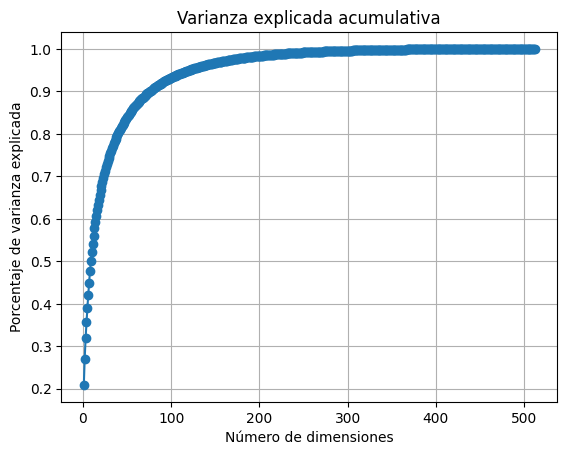

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Aplicar PCA sin reducir dimensiones (especificar n_components=None)
pca = PCA(n_components=None)
pca.fit(embeddings_)

# Obtener la varianza explicada acumulativa
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Graficar la varianza acumulativa
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.title('Varianza explicada acumulativa')
plt.xlabel('Número de dimensiones')
plt.ylabel('Porcentaje de varianza explicada')
plt.grid()
plt.show()


In [ ]:
optimal_dimensions = next(i for i, val in enumerate(cumulative_variance) if val >= 0.90) + 1
print(f'Dimensiones óptimas: {optimal_dimensions}')

Dimensiones óptimas: 76


## Reduciendo dimensionalidad a 76

In [ ]:
from sklearn.decomposition import PCA

# Crear el modelo PCA con las dimensiones óptimas
pca = PCA(n_components=68)


reduced_embeddings = pca.fit_transform(embeddings_)

In [ ]:
reduced_embeddings

array([[-1.4211018e+01, -5.7151437e-01, -2.3343396e-01, ...,
         7.2691194e-03,  7.5333435e-03,  9.3887029e-03],
       [ 8.1686745e+00,  8.9743099e+00,  1.3164470e+00, ...,
        -8.4652805e-01,  1.7779623e+00, -1.0660933e+00],
       [ 9.0024014e+00,  9.7745838e+00,  2.5629582e+00, ...,
        -1.9125873e-01,  1.1647305e+00,  7.7700967e-01],
       ...,
       [ 6.1036658e+00, -4.8977537e+00,  5.8030186e+00, ...,
         6.8584853e-01,  4.8155218e-02,  2.3826787e-01],
       [ 3.9142547e+00, -1.8362837e-01,  2.4569452e+00, ...,
         1.2794312e+00,  2.6081388e+00, -2.4251347e+00],
       [ 8.6740341e+00,  3.7069960e+00,  1.7057724e+00, ...,
         6.1507034e-01,  3.3554399e-01,  4.4656050e-01]], dtype=float32)

In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score,silhouette_score

# Valores para los índices Davies-Bouldin y Calinski-Harabasz
davies_bouldin_scores_1 = []
calinski_harabasz_scores_1 = []
inertia_1 = []
silhouette_1 = []
range_n_clusters = range(2, 50)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_embeddings)

    # Calcular los índices
    db_score = davies_bouldin_score(embeddings, kmeans.labels_)
    ch_score = calinski_harabasz_score(embeddings, kmeans.labels_)

    davies_bouldin_scores_1.append(db_score)
    calinski_harabasz_scores_1.append(ch_score)
    inertia_1.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
    silhouette_1.append(silhouette_avg)

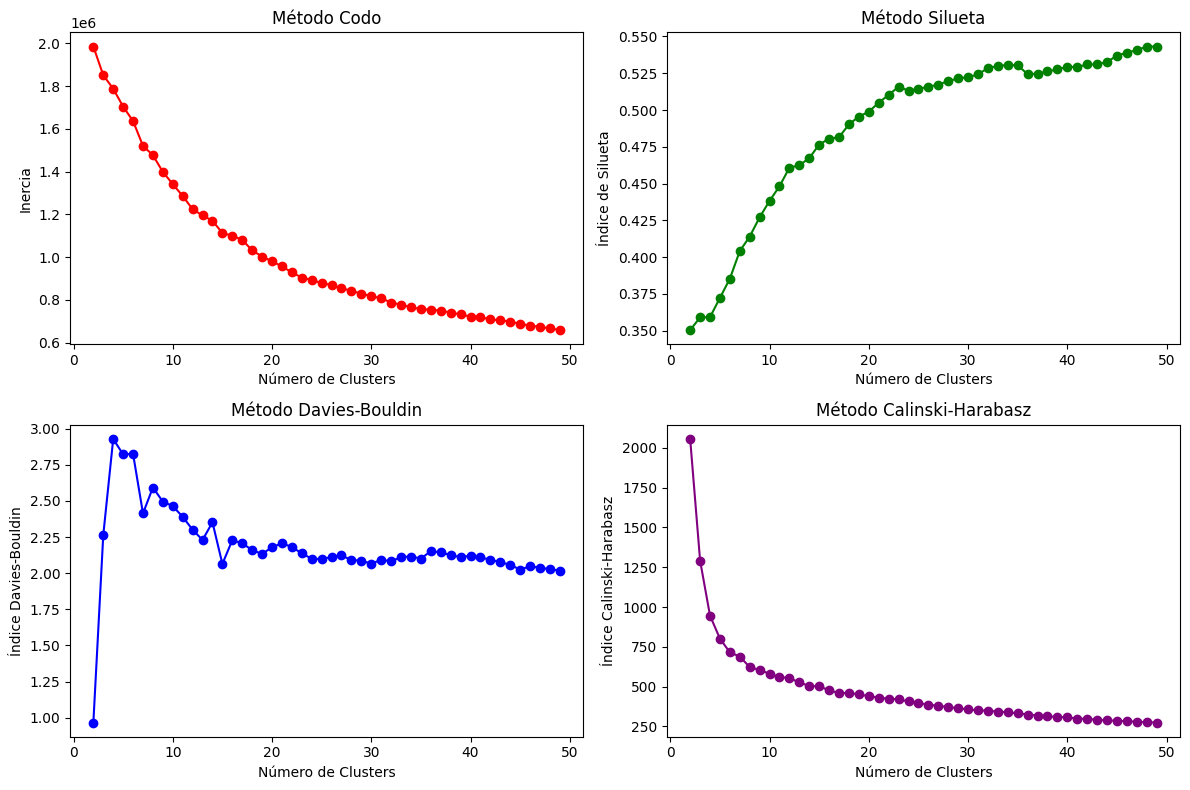

In [ ]:
# Graficar todas las métricas
plt.figure(figsize=(12, 8))

# Graficar el Método del Codo (Inercia)
plt.subplot(2, 2, 1)
plt.plot(range_n_clusters, inertia_1, marker='o', color='r')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método Codo')

# Graficar el Índice de Silueta
plt.subplot(2, 2, 2)
plt.plot(range_n_clusters, silhouette_1, marker='o', color='g')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silueta')
plt.title('Método Silueta')

# Graficar el Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(range_n_clusters, davies_bouldin_scores_1, marker='o', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice Davies-Bouldin')
plt.title('Método Davies-Bouldin')

# Graficar el Calinski-Harabasz Index
plt.subplot(2, 2, 4)
plt.plot(range_n_clusters, calinski_harabasz_scores_1, marker='o', color='purple')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice Calinski-Harabasz')
plt.title('Método Calinski-Harabasz')

# Ajustar la disposición y mostrar la gráfica
plt.tight_layout()
plt.show()

In [ ]:
# Elegir número de clusters
n_clusters = 13
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster_pca'] = kmeans.fit_predict(reduced_embeddings)
data

,Unnamed: 0,t1txt,cluster_umap,cluster_pca
0,0,NO SABE,1,0
1,1,VIOLACION A MENORES DE EDAD,7,1
2,2,EL NARCOTRAFICO EL FEMINICIDIO,2,11
3,5,LA DISCRIMINACION,2,2
4,6,EL NARCOTRAFICO,2,11
...,...,...,...,...
5667,8295,LA AGRICULTURA ESTA OLVIDADA LOS MAYORISTAS PA...,2,2
5668,8296,ORDEN EN EL PERU Y MANO DURA,2,2
5669,8297,AUTORIDADES QUE TRABAJEN BIEN,2,2
5670,8298,POR LA FORMA DE SER CADA PERSONA,2,2


In [ ]:
db_score = davies_bouldin_score(reduced_embeddings, kmeans.labels_)
ch_score = calinski_harabasz_score(reduced_embeddings, kmeans.labels_)
inertia_1 = kmeans.inertia_
silhouette_avg_1= silhouette_score(reduced_embeddings, kmeans.labels_)

In [ ]:
df = pd.DataFrame({
    'Inercia': [inertia_1],
    'Davies-Bouldin': [db_score],
    'Calinski-Harabasz': [ch_score],
    'Silhouette': [silhouette_avg_1]
})

In [ ]:
df

,Inercia,Davies-Bouldin,Calinski-Harabasz,Silhouette
0,1195335.625,2.038985,542.979529,0.47909


## UMAP

In [ ]:
# Crear el modelo UMAP para reducir a 2 dimensiones
reducer = umap.UMAP(n_components=80)

In [ ]:
!pip install umap-learn

import umap.umap_ as umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
embeddings_1 = reducer.fit_transform(embeddings_)

In [ ]:
# Elegir número de clusters
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster_umap'] = kmeans.fit_predict(embeddings_1)
data

,Unnamed: 0,t1txt,cluster_umap,cluster_pca
0,0,NO SABE,2,0
1,1,VIOLACION A MENORES DE EDAD,6,1
2,2,EL NARCOTRAFICO EL FEMINICIDIO,1,11
3,5,LA DISCRIMINACION,1,2
4,6,EL NARCOTRAFICO,1,11
...,...,...,...,...
5667,8295,LA AGRICULTURA ESTA OLVIDADA LOS MAYORISTAS PA...,1,2
5668,8296,ORDEN EN EL PERU Y MANO DURA,1,2
5669,8297,AUTORIDADES QUE TRABAJEN BIEN,1,2
5670,8298,POR LA FORMA DE SER CADA PERSONA,1,2


In [ ]:
db_score = davies_bouldin_score(embeddings_1, kmeans.labels_)
ch_score = calinski_harabasz_score(embeddings_1, kmeans.labels_)
inertia_1 = kmeans.inertia_
silhouette_avg_1= silhouette_score(embeddings_1, kmeans.labels_)

df_1 = pd.DataFrame({
    'Inercia': [inertia_1],
    'Davies-Bouldin': [db_score],
    'Calinski-Harabasz': [ch_score],
    'Silhouette': [silhouette_avg_1]
})
df_1

,Inercia,Davies-Bouldin,Calinski-Harabasz,Silhouette
0,80929.320312,0.599442,3939.305055,0.644985
